In [64]:
# ================================
# 1. Data Retrieval and Preparation
# ================================

import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import os

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (5000 hourly bars)
prices = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                     interval=Interval.in_15_minute, n_bars=5000)

# Ensure the 'close' column is in numeric format
prices['close'] = pd.to_numeric(prices['close'], errors='coerce')

# Drop any rows with NaN values in 'close'
prices.dropna(subset=['close'], inplace=True)

# Reset index if necessary
prices.reset_index(drop=True, inplace=True)

# Verify total data points after cleaning
total_data_points = prices.shape[0]
print(f"Total data points after cleaning: {total_data_points}")

# ================================
# 2. Hyperparameter Optimization
# ================================

# Define error metric: Root Mean Squared Error (RMSE)
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Fixed parameters
fixed_train_size = 4000       # Fixed training size
fixed_seasonal = False        # Fixed seasonality
window_length = 19             # Fixed window_length for Savitzky-Golay filter
polyorder = 1                  # Fixed polyorder for Savitzky-Golay filter
forecast_elements = 20         # Number of data points to forecast (5 hours)
shift_step = 12                # Shift each run by 12 data points
num_runs = 40                  # Number of rolling window iterations
error_ratio = 3                # Ratio of data points to use for error calculation, suggested from 1 to 4

# Optimization variables
seasonal_data_lengths = [100, 200, 400, 800, 1600]
num_harmonics_list = [10, 20, 40, 60, 80]

# Initialize a list to store results
results = []

# Loop through each combination of seasonal_data_length and num_harmonics
for seasonal_data_length in seasonal_data_lengths:
    for num_harmonics in num_harmonics_list:
        rmse_list = []
        print(f"\nOptimizing for seasonal_data_length={seasonal_data_length}, num_harmonics={num_harmonics}...")

        for run in range(num_runs):
            # Define shift for rolling window
            shift = run * shift_step

            # Calculate indices for slicing using positive indices
            start_idx = total_data_points - (fixed_train_size + forecast_elements + shift)
            end_train_idx = total_data_points - (forecast_elements + shift)
            test_start_idx = end_train_idx
            test_end_idx = end_train_idx + forecast_elements

            # Ensure indices are within bounds
            if start_idx < 0 or test_end_idx > total_data_points:
                print(f"  Skipping run {run} due to insufficient data (shift={shift}).")
                continue

            # Slice the data for training and testing
            train_prices = prices.iloc[start_idx:end_train_idx].copy()
            test_prices = prices.iloc[test_start_idx:test_end_idx].copy()

            # Verify that slicing has the correct number of data points
            if len(train_prices) != fixed_train_size or len(test_prices) != forecast_elements:
                print(f"  Run {run} failed: Incorrect slice sizes (train_size={len(train_prices)}, test_size={len(test_prices)}).")
                rmse_list.append(np.nan)
                continue

            # Combine train and test prices
            combined_prices = pd.concat([train_prices, test_prices], ignore_index=True)

            # Apply Savitzky-Golay filter to combined_prices to get trend_total
            try:
                trend_total = savgol_filter(combined_prices['close'], window_length=window_length, polyorder=polyorder)
                trend_train = trend_total[:len(train_prices)]
                trend_test = trend_total[len(train_prices):]
                # Compute seasonal components
                seasonal_train = train_prices['close'].values - trend_train
                seasonal_test = test_prices['close'].values - trend_test
            except ValueError as e:
                print(f"  Run {run} failed during Savitzky-Golay filter on combined data: {e}")
                rmse_list.append(np.nan)
                continue

            # Seasonal Component Forecasting using FFT
            try:
                # Determine the starting index for the seasonal data
                if seasonal_data_length > len(seasonal_train):
                    print(f"  Run {run} failed: seasonal_data_length={seasonal_data_length} exceeds available data.")
                    rmse_list.append(np.nan)
                    continue

                # Extract the last 'seasonal_data_length' points for FFT
                seasonal_data_for_fft = seasonal_train[-seasonal_data_length:]

                # Time indices for the existing data
                N_seasonal = len(seasonal_data_for_fft)
                total_length = N_seasonal + forecast_elements
                extended_indices = np.arange(total_length)

                # Perform FFT on the seasonal data
                fft_result = np.fft.fft(seasonal_data_for_fft)
                fft_freq = np.fft.fftfreq(N_seasonal)

                # Only need positive frequencies
                positive_freq_indices = fft_freq >= 0
                fft_freq_positive = fft_freq[positive_freq_indices]
                fft_result_positive = fft_result[positive_freq_indices]

                # Retain only the first 'num_harmonics' harmonics
                if num_harmonics > len(fft_result_positive):
                    print(f"  Run {run} failed: num_harmonics={num_harmonics} exceeds available harmonics ({len(fft_result_positive)}).")
                    rmse_list.append(np.nan)
                    continue

                frequencies = fft_freq_positive[:num_harmonics]
                amplitudes = fft_result_positive[:num_harmonics]

                # Reconstruct the seasonal signal with forecast
                reconstructed_seasonal = np.zeros(total_length)

                for i in range(num_harmonics):
                    frequency = frequencies[i]
                    amplitude = amplitudes[i]
                    omega = 2 * np.pi * frequency
                    phase = np.angle(amplitude)
                    if frequency == 0:
                        # DC component
                        reconstructed_seasonal += amplitude.real / N_seasonal
                    else:
                        # Harmonic components
                        reconstructed_seasonal += (2 * np.abs(amplitude) / N_seasonal) * np.cos(omega * extended_indices + phase)

                # Extract the forecasted seasonal component
                seasonal_forecast = reconstructed_seasonal[-forecast_elements:]
            except Exception as e:
                print(f"  Run {run} failed during FFT processing: {e}")
                rmse_list.append(np.nan)
                continue

            # Calculate RMSE between seasonal forecast and actual seasonal test data
            seasonal_data_for_error = np.append(seasonal_data_for_fft[-forecast_elements*error_ratio:], seasonal_test)
            seasonal_forecast_for_error = reconstructed_seasonal[-forecast_elements*(1+error_ratio):]
            rmse = calculate_rmse(seasonal_data_for_error, seasonal_forecast_for_error)
            rmse_list.append(rmse)

        # Calculate average RMSE across all runs, ignoring NaN values
        if rmse_list:
            avg_rmse = np.nanmean(rmse_list)
        else:
            avg_rmse = np.nan

        # Store the results
        results.append({
            'seasonal_data_length': seasonal_data_length,
            'num_harmonics': num_harmonics,
            'avg_rmse': avg_rmse
        })

        print(f"  Completed: seasonal_data_length={seasonal_data_length}, num_harmonics={num_harmonics}, avg_rmse={avg_rmse:.4f}")


ERROR:tvDatafeed.main:error while signin


Total data points after cleaning: 5000

Optimizing for seasonal_data_length=100, num_harmonics=10...
  Completed: seasonal_data_length=100, num_harmonics=10, avg_rmse=1.9571

Optimizing for seasonal_data_length=100, num_harmonics=20...
  Completed: seasonal_data_length=100, num_harmonics=20, avg_rmse=1.7732

Optimizing for seasonal_data_length=100, num_harmonics=40...
  Completed: seasonal_data_length=100, num_harmonics=40, avg_rmse=1.7011

Optimizing for seasonal_data_length=100, num_harmonics=60...
  Run 0 failed: num_harmonics=60 exceeds available harmonics (50).
  Run 1 failed: num_harmonics=60 exceeds available harmonics (50).
  Run 2 failed: num_harmonics=60 exceeds available harmonics (50).
  Run 3 failed: num_harmonics=60 exceeds available harmonics (50).
  Run 4 failed: num_harmonics=60 exceeds available harmonics (50).
  Run 5 failed: num_harmonics=60 exceeds available harmonics (50).
  Run 6 failed: num_harmonics=60 exceeds available harmonics (50).
  Run 7 failed: num_harmo

/var/folders/t7/qhsh0qws38d4057943350r400000gn/T/ipykernel_99549/76145627.py:180: RuntimeWarning: Mean of empty slice
  avg_rmse = np.nanmean(rmse_list)


  Completed: seasonal_data_length=200, num_harmonics=20, avg_rmse=2.0303

Optimizing for seasonal_data_length=200, num_harmonics=40...
  Completed: seasonal_data_length=200, num_harmonics=40, avg_rmse=1.8810

Optimizing for seasonal_data_length=200, num_harmonics=60...
  Completed: seasonal_data_length=200, num_harmonics=60, avg_rmse=1.8367

Optimizing for seasonal_data_length=400, num_harmonics=10...
  Completed: seasonal_data_length=400, num_harmonics=10, avg_rmse=2.5191

Optimizing for seasonal_data_length=400, num_harmonics=20...
  Completed: seasonal_data_length=400, num_harmonics=20, avg_rmse=2.4017

Optimizing for seasonal_data_length=400, num_harmonics=40...
  Completed: seasonal_data_length=400, num_harmonics=40, avg_rmse=1.9975

Optimizing for seasonal_data_length=400, num_harmonics=60...
  Completed: seasonal_data_length=400, num_harmonics=60, avg_rmse=1.8754

Optimizing for seasonal_data_length=800, num_harmonics=10...
  Completed: seasonal_data_length=800, num_harmonics=10


Optimization Results:
    seasonal_data_length  num_harmonics  avg_rmse
0                    100             10  1.952403
1                    100             20  1.772377
2                    100             40  1.693101
3                    100             60       NaN
4                    100             80       NaN
5                    100            100       NaN
6                    200             10  2.434789
7                    200             20  2.015162
8                    200             40  1.863957
9                    200             60  1.817166
10                   200             80  1.788190
11                   200            100  1.757013
12                   400             10  2.513430
13                   400             20  2.392023
14                   400             40  1.974360
15                   400             60  1.857975
16                   400             80  1.793345
17                   400            100  1.779769
18                   800   

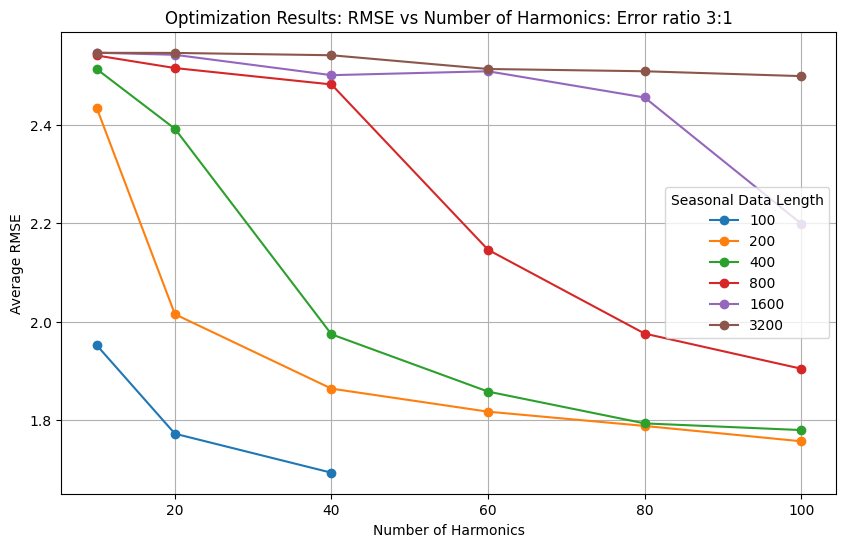

In [59]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Display the results
print("\nOptimization Results:")
print(results_df)

# Plotting RMSE vs Number of Harmonics for each Seasonal Data Length
plt.figure(figsize=(10, 6))

# Loop over each seasonal_data_length
for seasonal_length in seasonal_data_lengths:
    # Subset the results for the current seasonal_data_length
    subset = results_df[results_df['seasonal_data_length'] == seasonal_length]
    # Sort by num_harmonics to ensure correct plotting
    subset = subset.sort_values(by='num_harmonics')
    # Plot RMSE vs Number of Harmonics
    plt.plot(subset['num_harmonics'], subset['avg_rmse'], marker='o', label=f'{seasonal_length}')

plt.title(f'Optimization Results: RMSE vs Number of Harmonics: Error ratio {error_ratio}:1')
plt.xlabel('Number of Harmonics')
plt.ylabel('Average RMSE')
plt.legend(title='Seasonal Data Length')
plt.grid(True)
plt.show()

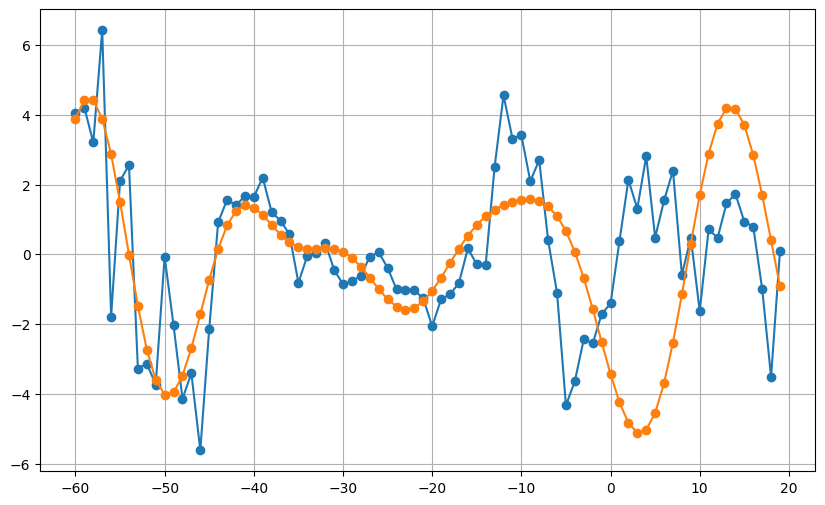

In [65]:

seasonal_data_for_error = np.append(seasonal_data_for_fft[-forecast_elements*(error_ratio):], seasonal_test)
seasonal_forecast_for_error = reconstructed_seasonal[-forecast_elements*(1+error_ratio):]

# Plotting RMSE vs Number of Harmonics for each Seasonal Data Length
plt.figure(figsize=(10, 6))
plt.plot(np.arange(-len(seasonal_data_for_error)+forecast_elements,forecast_elements), seasonal_data_for_error, marker='o', label=f'{seasonal_length}')
plt.plot(np.arange(-len(seasonal_forecast_for_error)+forecast_elements,forecast_elements), seasonal_forecast_for_error, marker='o', label=f'{seasonal_length}')
plt.grid(True)
plt.show()